In [25]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [26]:
%store -r ingest_create_athena_db_passed

In [27]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
from pyathena import connect

In [28]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

## Set Seaborn Parameters

In [29]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

## Helper Code to Display Values on Bars

In [30]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

In [31]:
#database name and table
database_name = "oneclickaws"

table_1 = "aisles"
table_2= "departments"
table_3= "order_products_prior"
table_4= "order_products_train"
table_5= "orders"
table_6= "products"

## total number of orders per customer

In [32]:
# SQL statement
exploration_1 = """
SELECT user_id,
       count (order_id)  AS Number_of_orders
         
FROM oneclickaws.orders
GROUP BY  user_id
order by Number_of_orders DESC


""".format(
    database_name, table_1
)


df_1= pd.read_sql(exploration_1, conn)
df_1.head(10)

,user_id,Number_of_orders
0,92366,100
1,54804,100
2,175729,100
3,72726,100
4,183651,100
5,54485,100
6,194619,100
7,72754,100
8,202623,100
9,169068,100


## Busiest day of the week

In [33]:
exploration_2 = """select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from {}.{}  
 group by order_dow 
 order by total_orders desc """.format(database_name,table_5)



df_2= pd.read_sql(exploration_2, conn)
df_2.head(5)

,total_orders,day_of_week
0,600905,Sunday
1,587478,Monday
2,467260,Tuesday
3,453368,Friday
4,448761,Saturday


In [34]:
orders_per_day = df_2

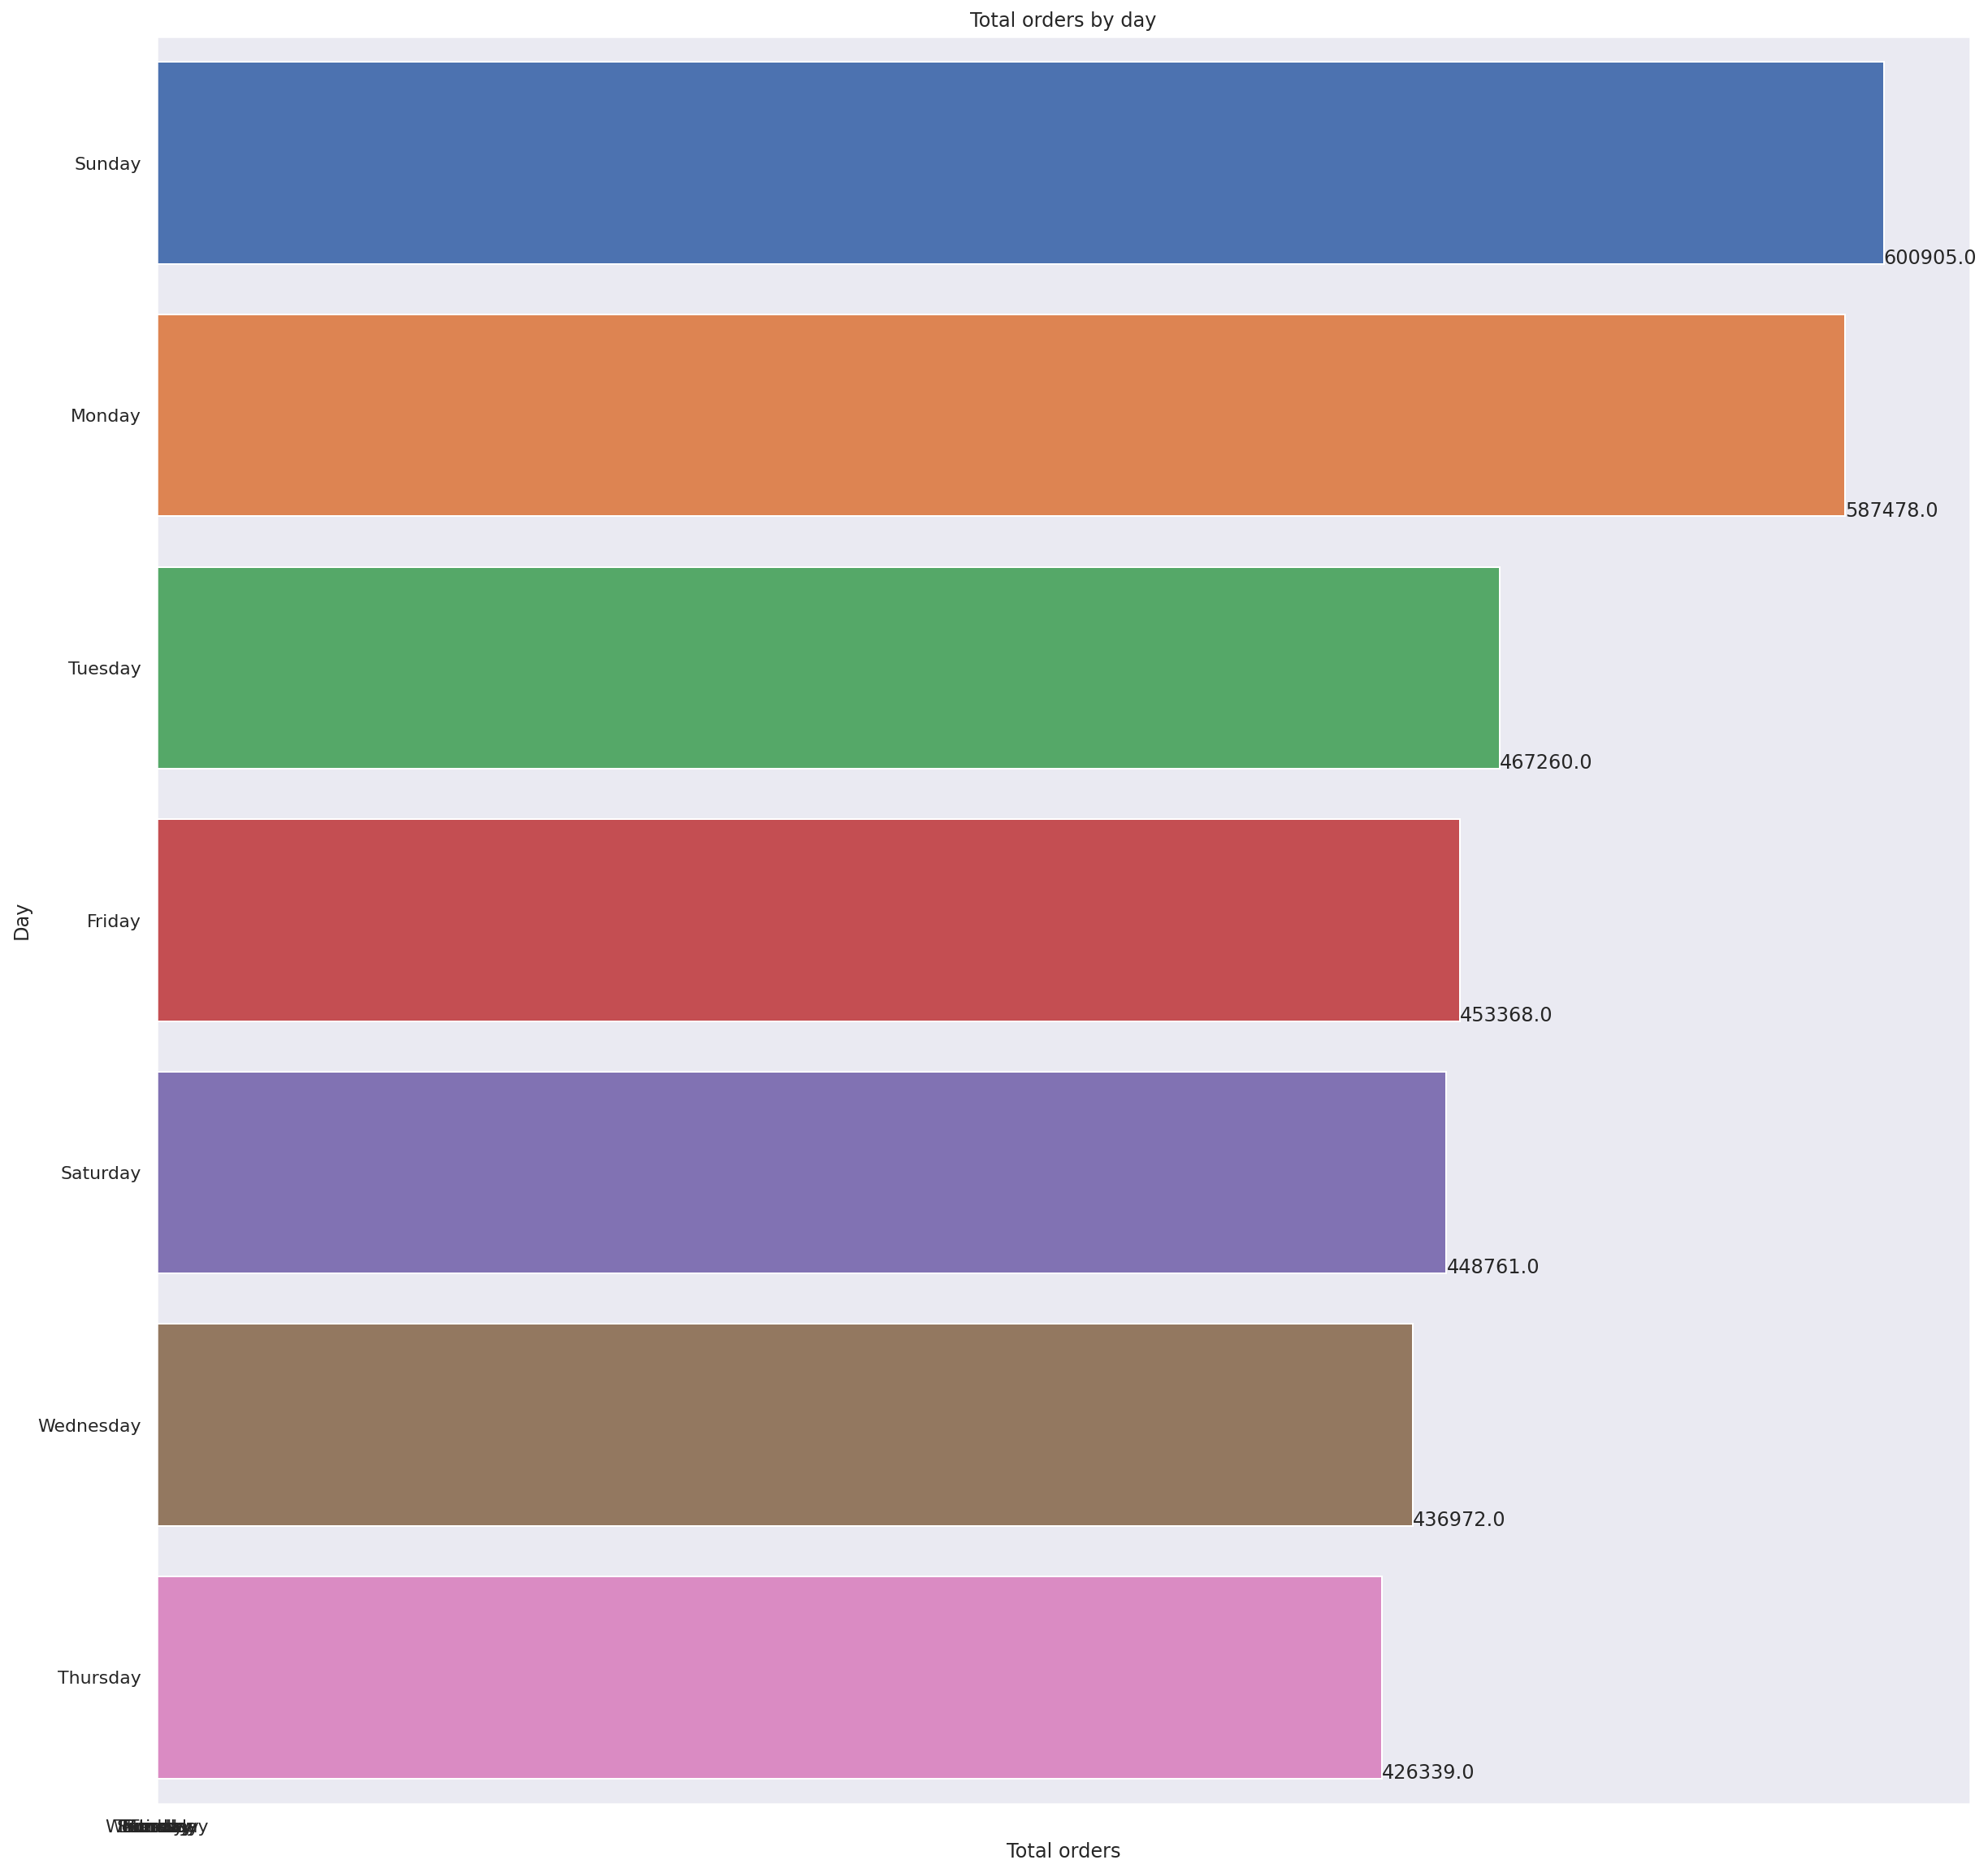

In [46]:
# Create plot
barplot = sns.barplot(y="day_of_week", x="total_orders", data=df_2, saturation=1)

# Set title and x-axis ticks
plt.title("Total orders by day")
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Total orders")
plt.ylabel("Day")

# Show graphic
plt.show(barplot)

## Total product ordered per department

In [36]:
exploration_3 = """select countbydept.*
  from (
  select department_id, count(1) as counter
    from oneclickaws.products
   group by department_id
   order by counter asc 
  ) as maxcount
inner join (
  select
    d.department_id,
    d.department,
    count(1) as products
    from oneclickaws.departments d
      inner join oneclickaws.products p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 

  on countbydept.products = maxcount.counter"""

df_3= pd.read_sql(exploration_3, conn)

df_3

,department_id,department,products
0,18,babies,938
1,5,alcohol,964
2,6,international,1049
3,4,produce,1642
4,17,household,2839
5,1,frozen,3770
6,10,bulk,52
7,10,bulk,52
8,10,bulk,52
9,2,other,524


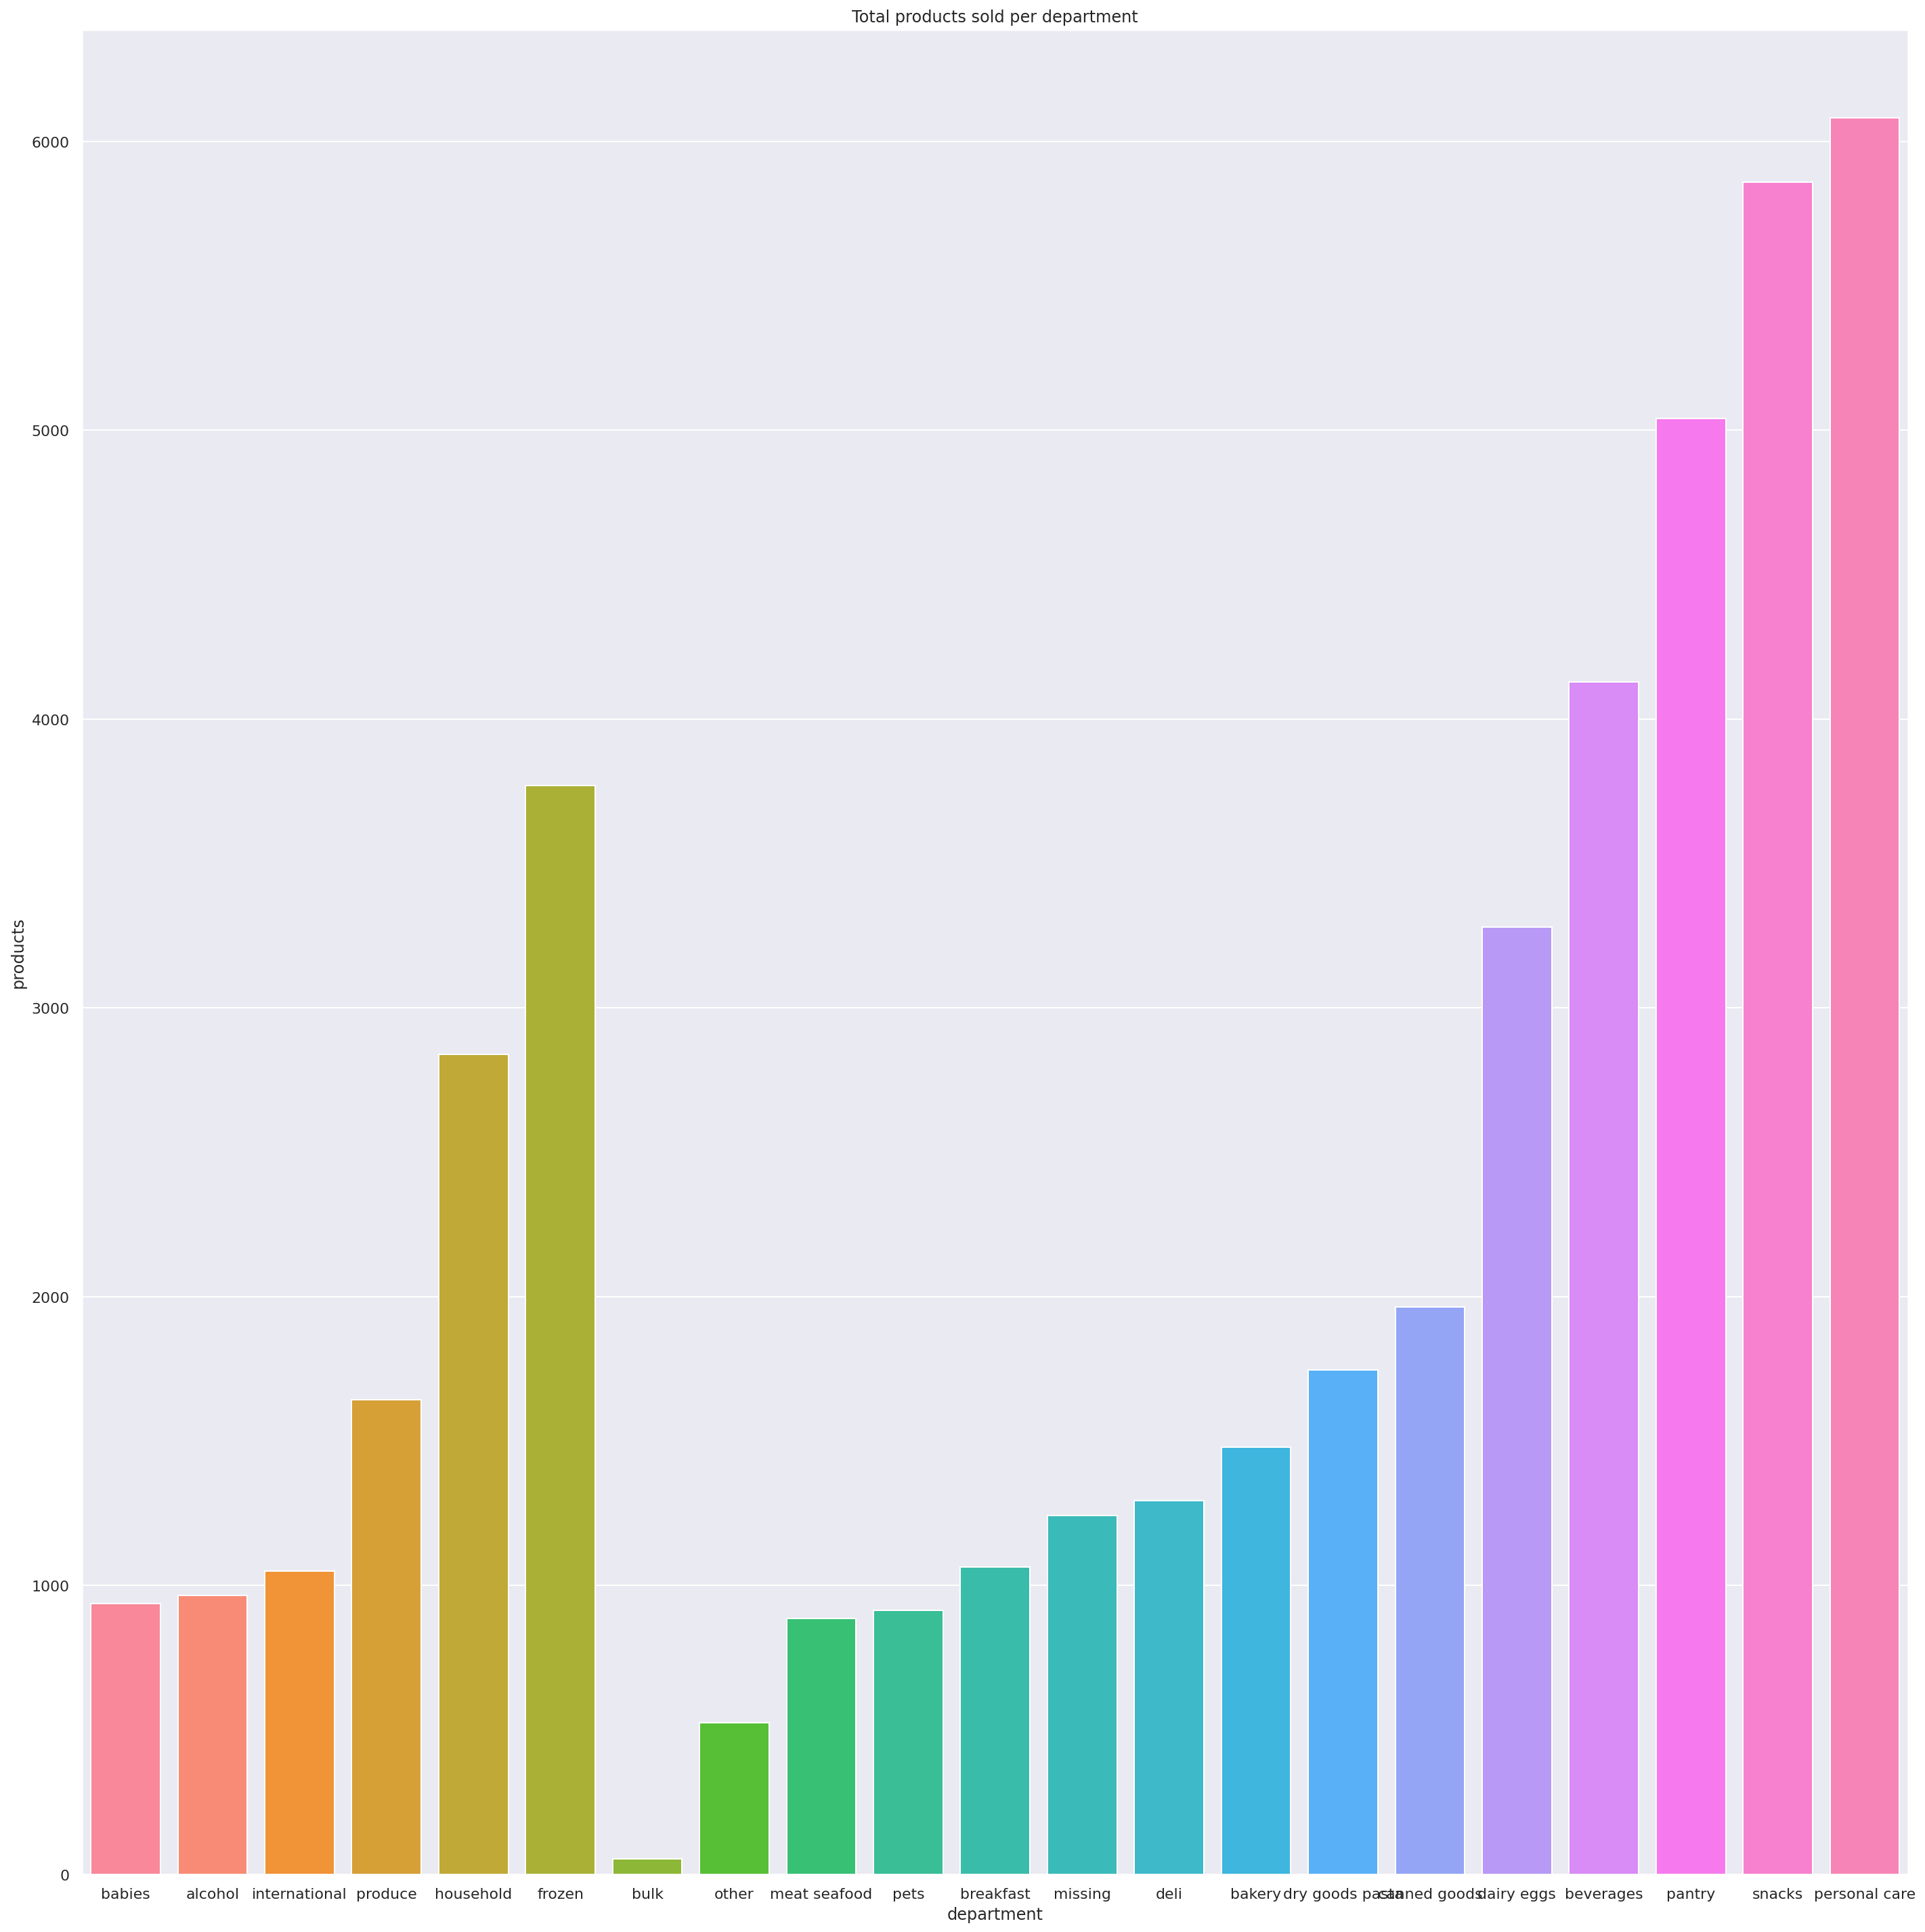

In [47]:
# Create plot
barplot = sns.barplot(x="department",y="products", data= df_3, saturation=1)


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Total products sold per department")
plt.xticks()

# code to show actual values afters bars


plt.xlabel("department")
plt.ylabel("products")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## analyze the hourly distribution

In [38]:
exploration_4 = """select 
  order_hour_of_day as hour_of_day,
  count(order_id) as total_orders
  
  from {}.{}  
 group by order_hour_of_day 
 order by hour_of_day  """.format(database_name,table_5)



df_4= pd.read_sql(exploration_4, conn)
df_4.head(25)

,hour_of_day,total_orders
0,00,22758
1,01,12398
2,02,7539
3,03,5474
4,04,5527
5,05,9569
6,06,30529
7,07,91868
8,08,178201
9,09,257812


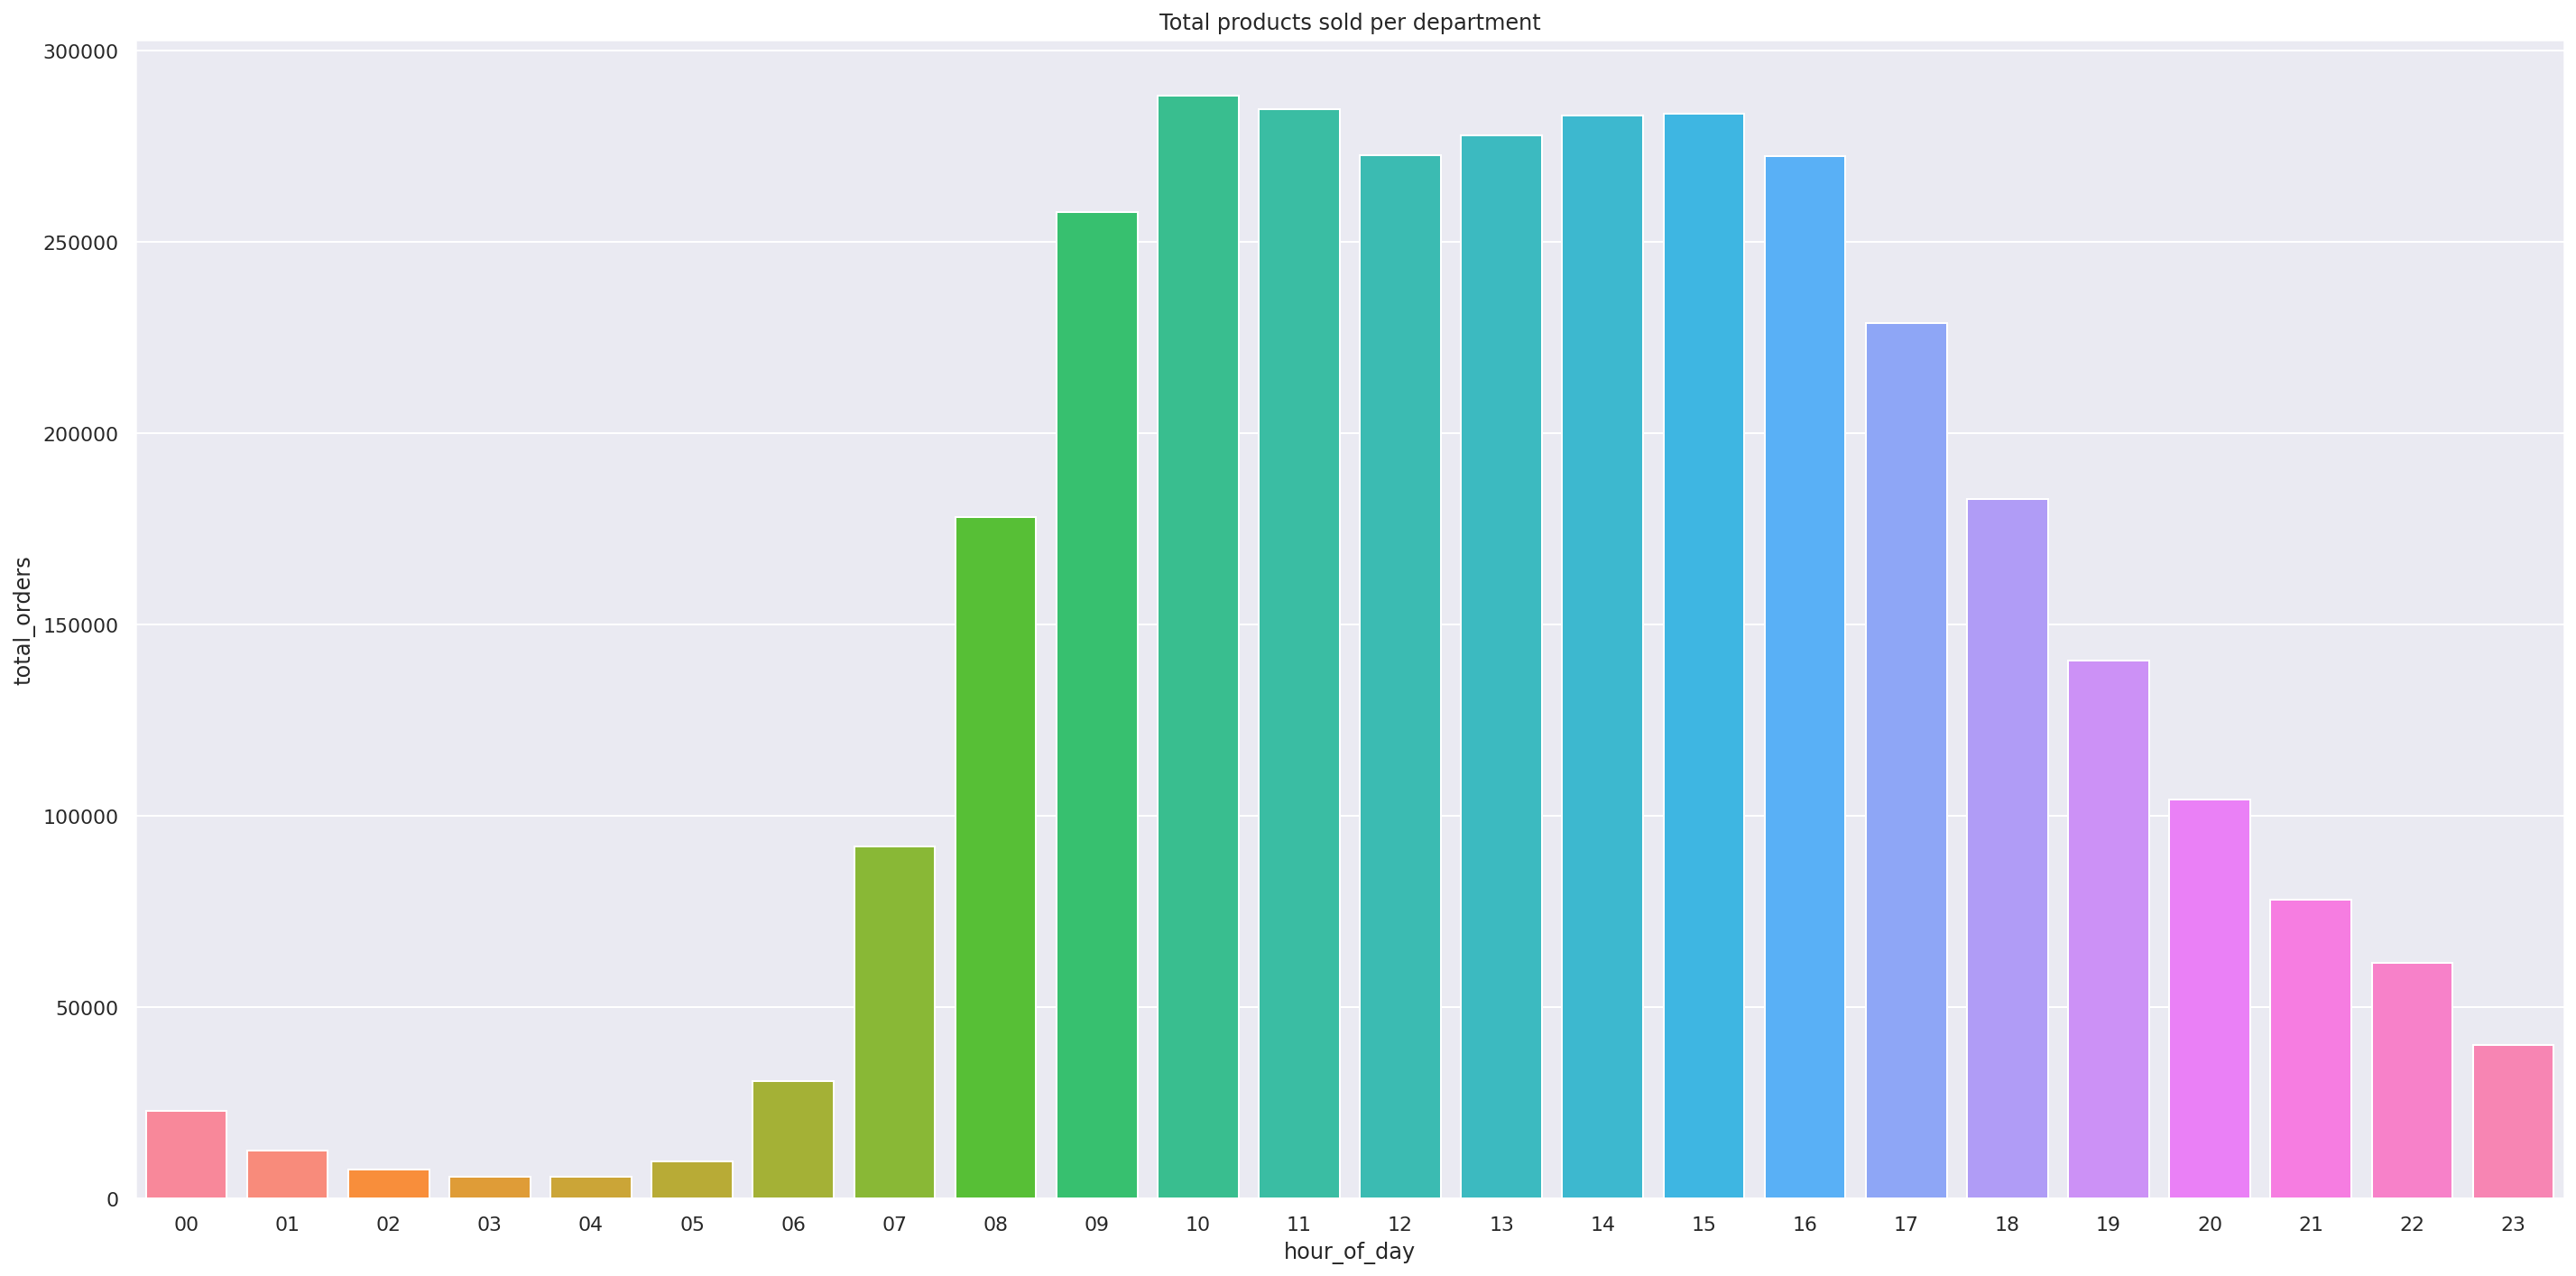

In [39]:
# Create plot
barplot = sns.barplot(x="hour_of_day",y="total_orders", data= df_4, saturation=1)


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Total products sold per department")
plt.xticks()

# code to show actual values afters bars


plt.xlabel("hour_of_day")
plt.ylabel("total_orders")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)


## Top 20 purchased products

In [40]:
exploration_5 = """SELECT count(opp.order_id) as orders, p.product_name 
  FROM oneclickaws.order_products_prior opp, oneclickaws.products p
  where p.product_id = opp.product_id 
  group by product_name 
  order by orders desc 
  limit 20"""

df_5= pd.read_sql(exploration_5, conn)

df_5.head()

,orders,product_name
0,472565,Banana
1,379450,Bag of Organic Bananas
2,264683,Organic Strawberries
3,241921,Organic Baby Spinach
4,213584,Organic Hass Avocado


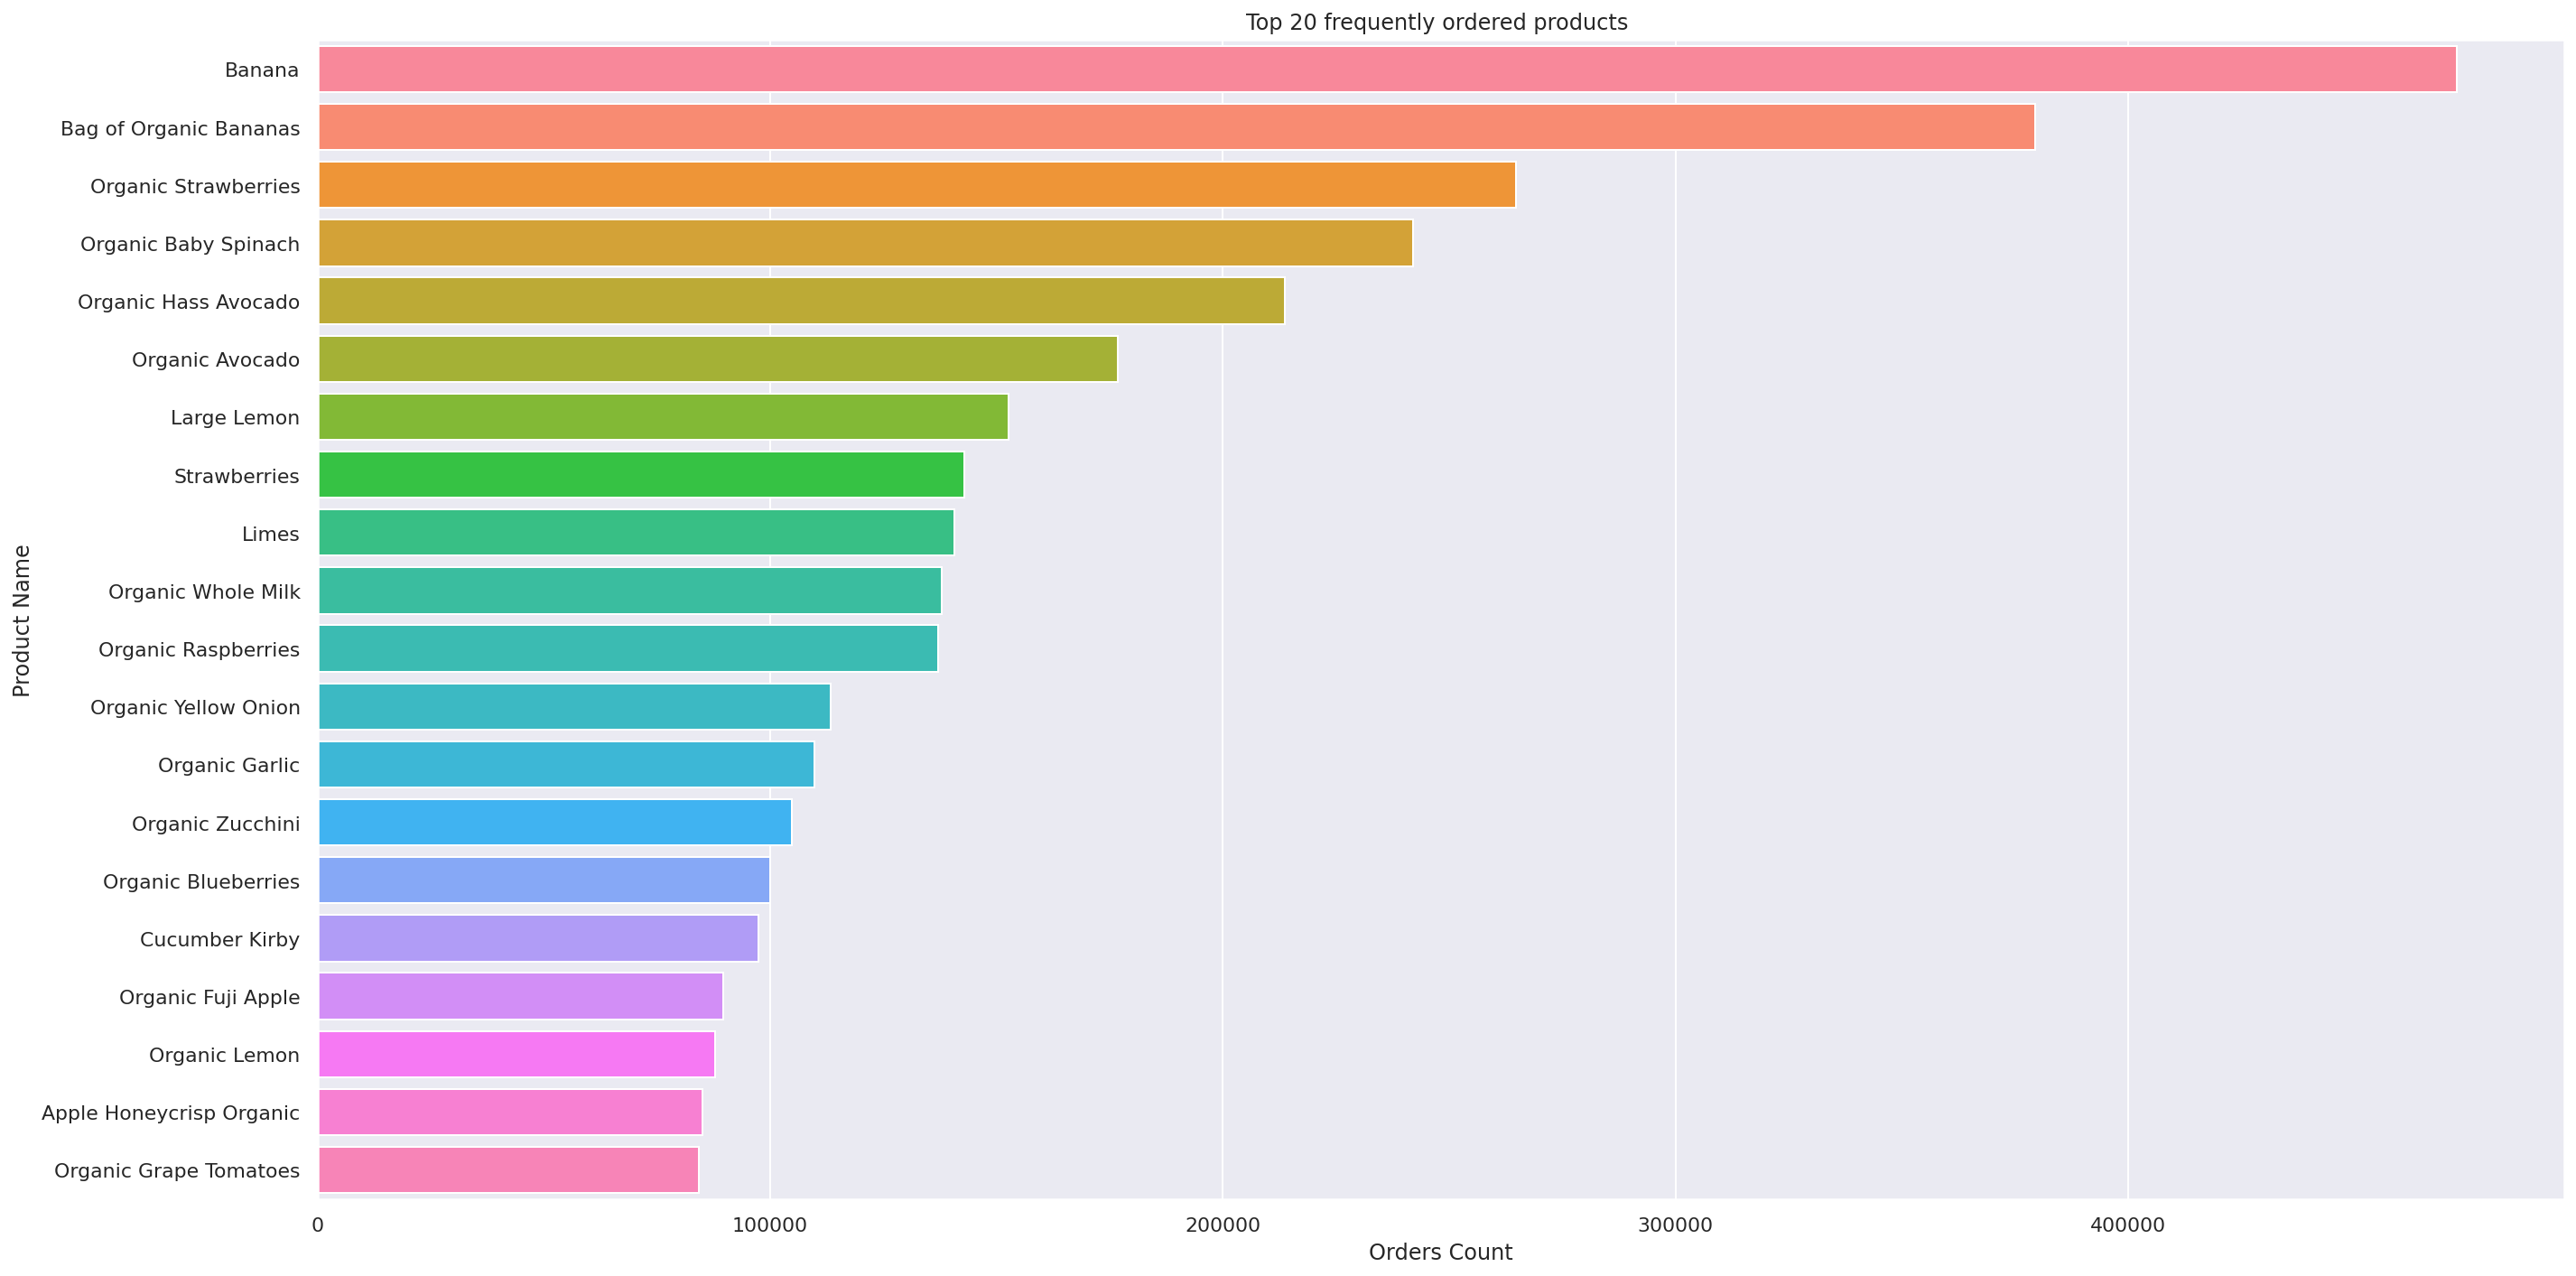

In [41]:
# Create plot
barplot = sns.barplot(x="orders",y="product_name", data= df_5, saturation=1, orient = 'h')


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Top 20 frequently ordered products ")
plt.xticks()

# code to show actual values afters bars


plt.ylabel("Product Name")
plt.xlabel("Orders Count")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Most Busy Hours

In [42]:
exploration_6 =  """Select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from oneclickaws.orders 
 group by order_hour_of_day 
 order by order_hour_of_day"""

df_6= pd.read_sql(exploration_6, conn)

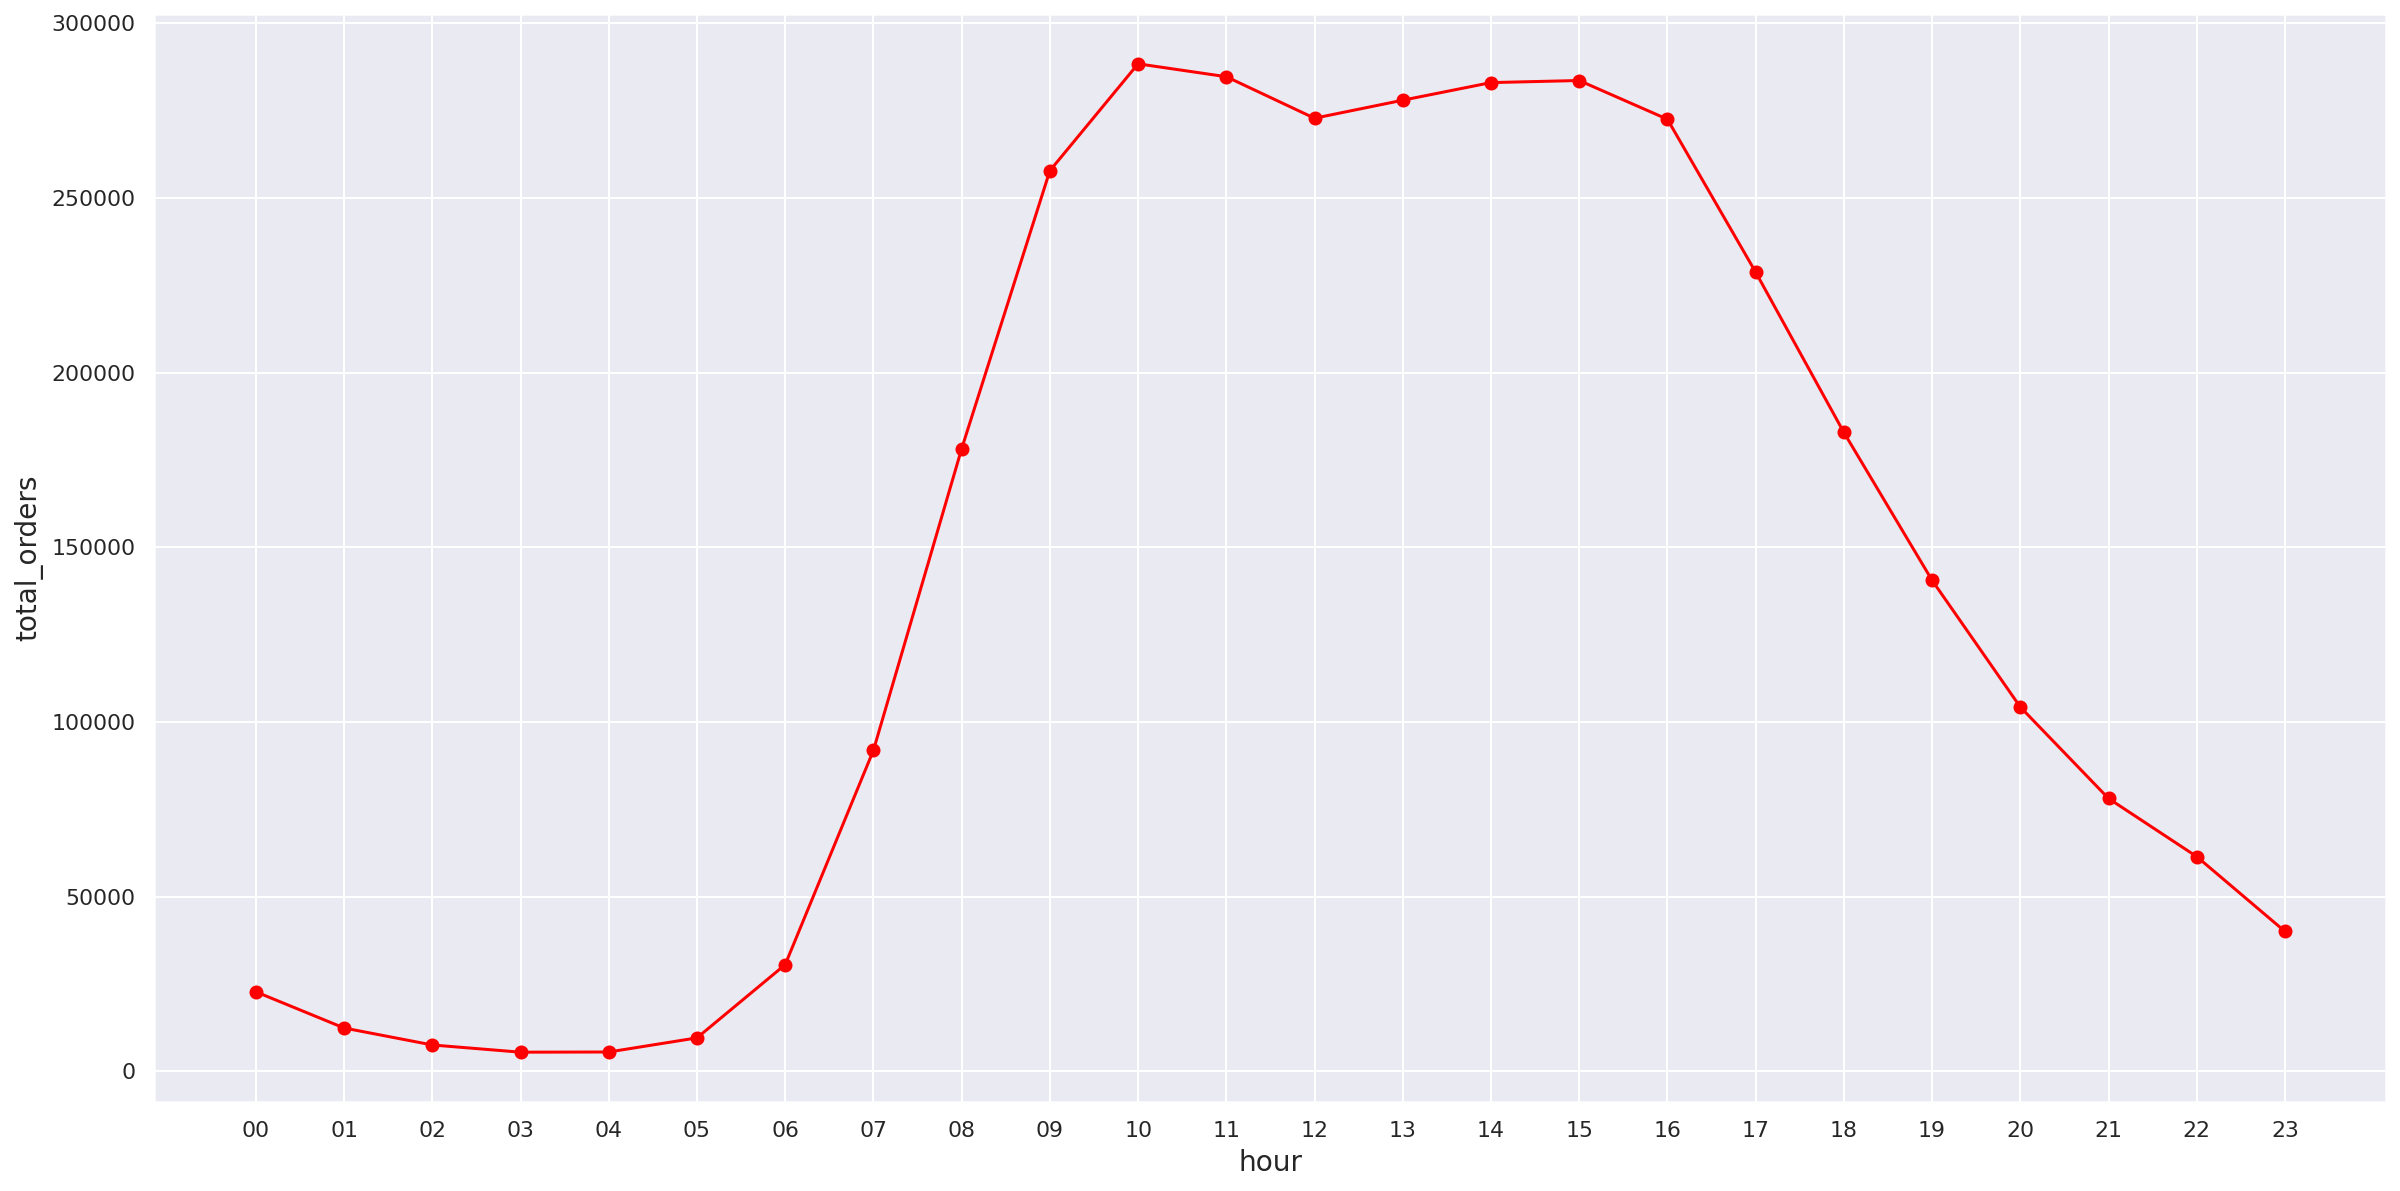

In [43]:
import matplotlib.pyplot as plt

plt.plot(df_6['hour'], df_6['total_orders'], color='red', marker='o')
plt.ylabel('total_orders', fontsize=14)
plt.xlabel('hour', fontsize=14)
plt.grid(True)
plt.show()

## Frequently Reordered Products

In [44]:

exploration_7= """
SELECT product_name,
         COUNT(*) AS reordered_count
FROM oneclickaws.products p
INNER JOIN oneclickaws.order_products_train opp ON p.product_id = opp.product_id
WHERE reordered = '1'
GROUP BY  product_name 
order by reordered_count desc 
LIMIT 15
"""


df_7= pd.read_sql(exploration_7, conn)

df_7


,product_name,reordered_count
0,Banana,16557
1,Bag of Organic Bananas,13362
2,Organic Strawberries,8603
3,Organic Baby Spinach,8055
4,Organic Avocado,6226
5,Organic Hass Avocado,6042
6,Large Lemon,5923
7,Strawberries,4786
8,Organic Raspberries,4279
9,Limes,4234


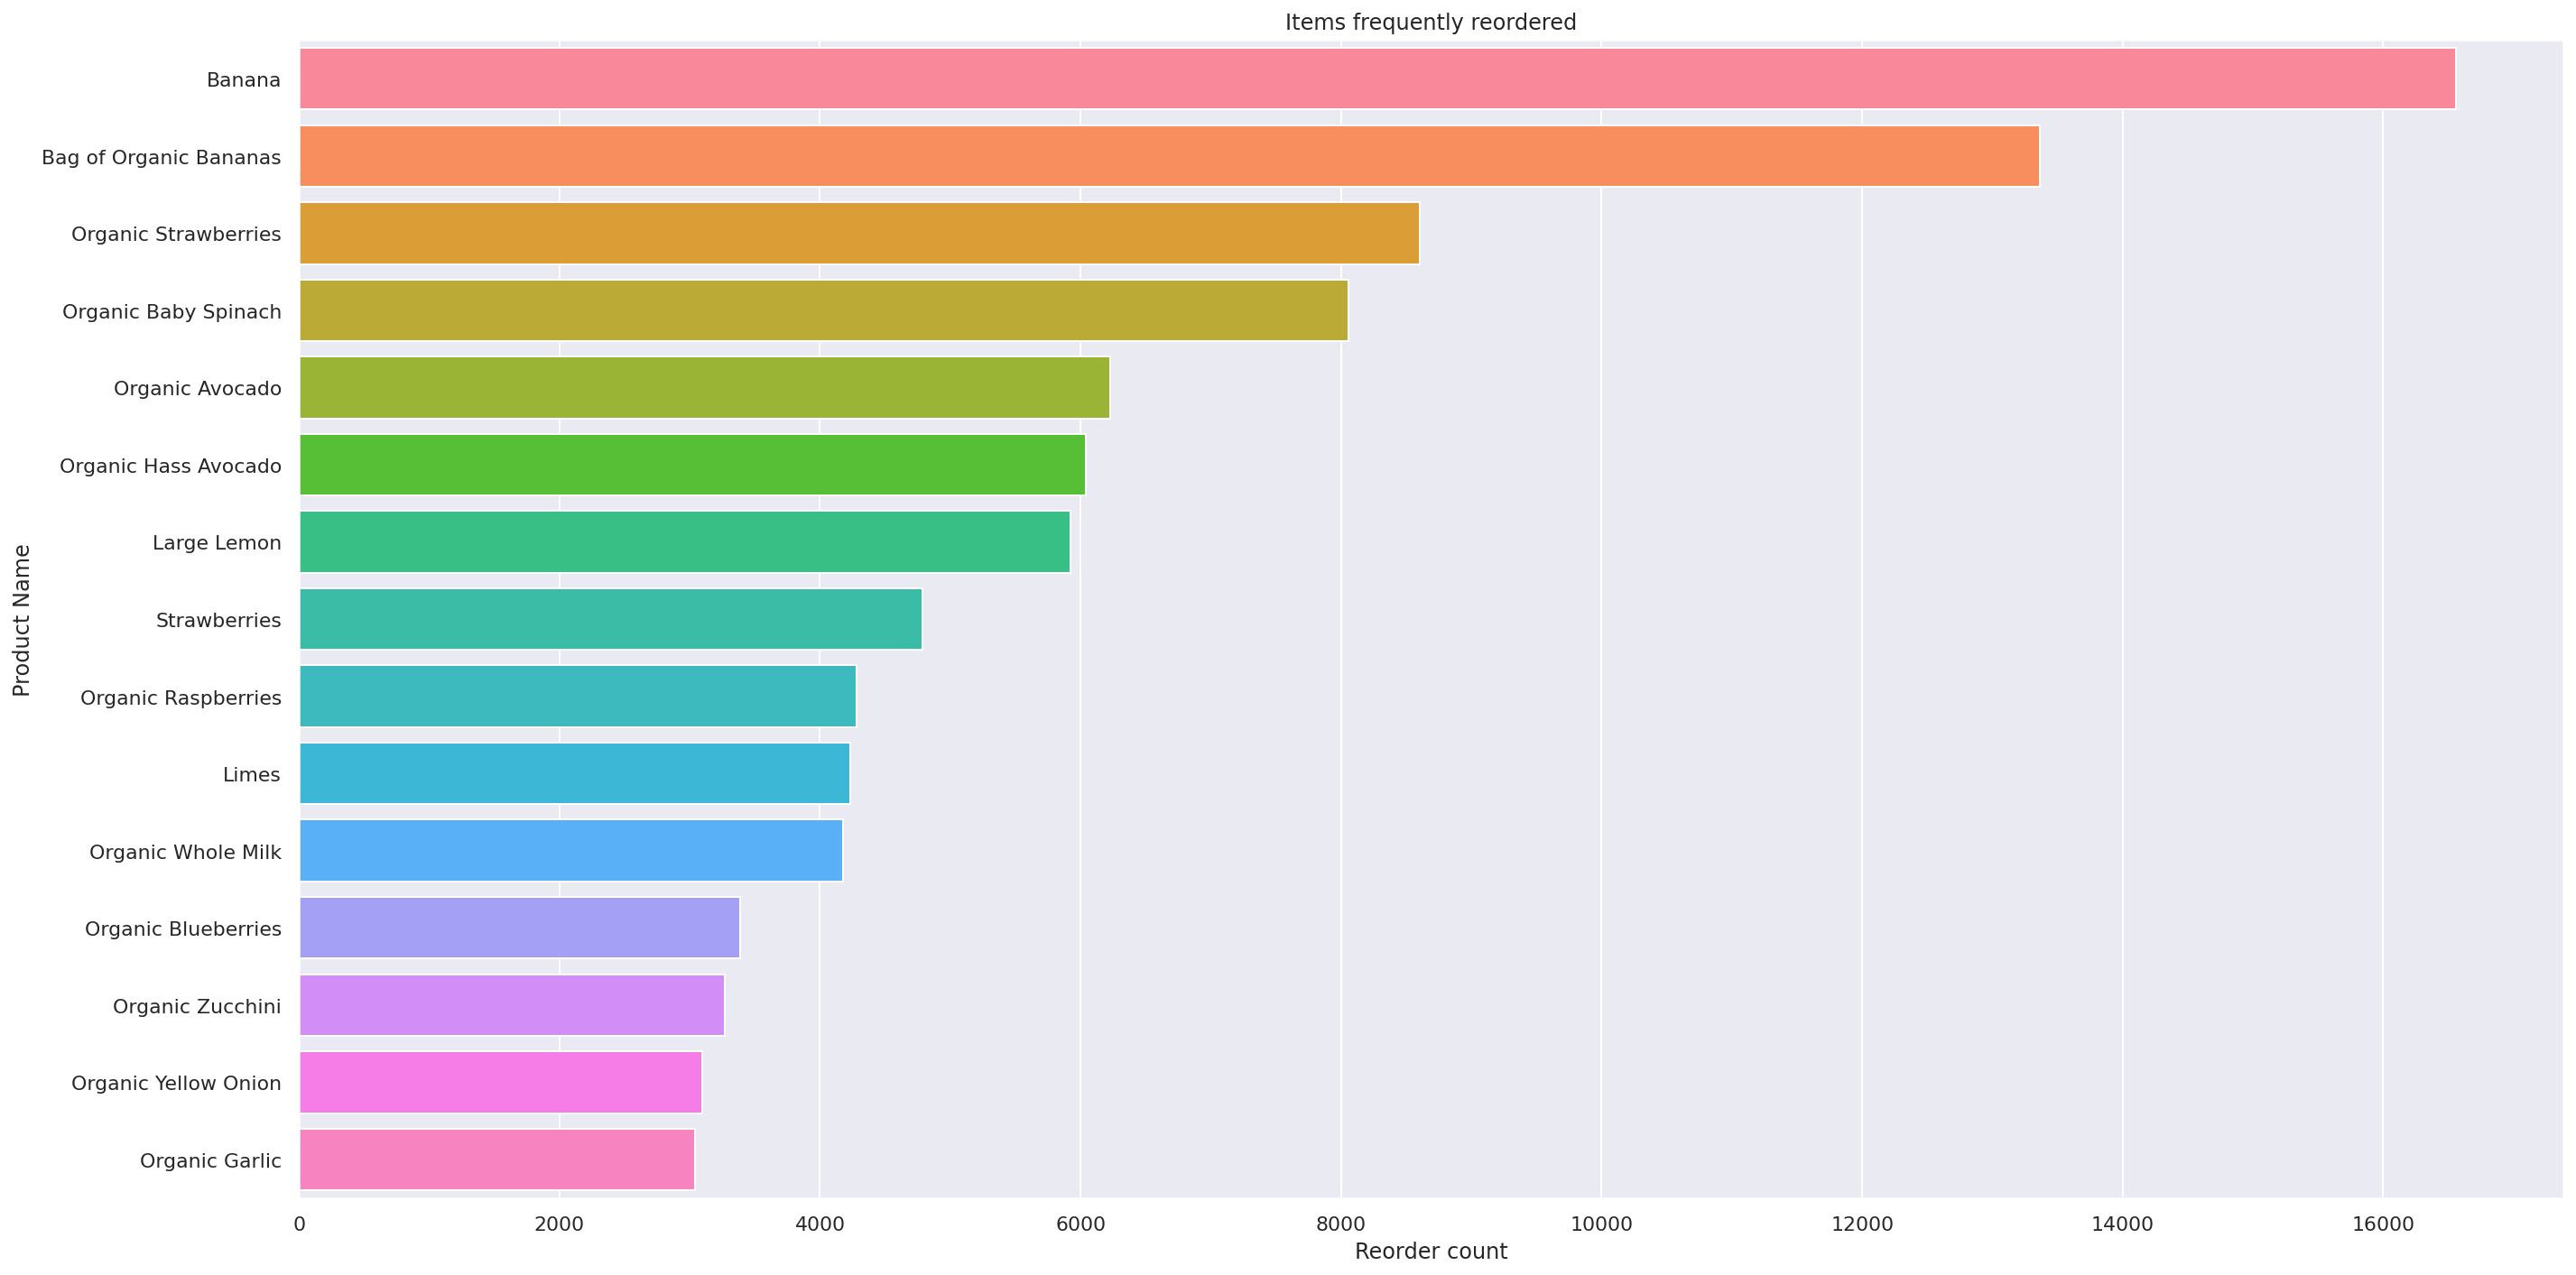

In [45]:
# Create plot
barplot = sns.barplot(x="reordered_count",y="product_name", data= df_7, saturation=1)


sns.set(rc={"figure.figsize": (20.0, 20.0)})

# Set title and x-axis ticks
plt.title("Items frequently reordered")
plt.xticks()

# code to show actual values afters bars


plt.xlabel("Reorder count")
plt.ylabel("Product Name")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)